In [ ]:
第一題 [myknn_regressor]
首先，載入資料，並將X_train、Y_train、X_test、Y_test分別存入array。

In [1]:
import numpy as np
import pickle

# load data: X_train, Y_train, X_test, Y_test
with (open("msd_data1.pickle", "rb")) as openfile:
    while True:
        try:
            dataset = pickle.load(openfile)        
        except EOFError:
            break

X_train = np.array(dataset['X_train']) # 90*5000 2D-array
Y_train = np.array(dataset['Y_train']) # 5000 1D-array
X_test = np.array(dataset['X_test']) # 90*3000 2D-array
Y_test = np.array(dataset['Y_test']) # 3000 1D-array


In [ ]:
myknn_regressor類別，含有以下function:
    EuclidianDistance: 傳入兩一維陣列，計算兩個feature陣列的EuclidianDistance
    remove_outliers: 移除不在[Q1−1.5IQR,Q3+1.5IQR]的離群值
    fit: 傳入X_train, Y_train，做assign
    predict: 傳入X_test，計算X_train與每一筆X_test的距離，取最近的K個，並利用這些feature所對應的Y_train之平均做為預測的y      
其他function:
    RMSE: 傳入兩陣列(預測值及實際值)，計算誤差
    Standardize: 傳入陣列做標準化

In [2]:
import numpy as np
import copy

# create class myknn_regressor
class myknn_regressor:
    
    def __init__(self, k, method): 
        self.k = k 
        self.method = method
        self.X_train = []
        self.Y_train = []
        
    # fit the data 
    def fit(self, X_train, Y_train):
        
        self.X_train = X_train.copy()
        self.Y_train = Y_train.copy()
    
    # calculate the Euclidian Distance
    def EuclidianDistance(self, data1, data2, length):
        return np.sqrt(np.sum((data1 - data2) ** 2))
        
    def remove_outliers(self, data):
        
        data_removeOutlier = []
        IQR = np.quantile(data, 0.75) - np.quantile(data, 0.25)
        lb = np.quantile(data, 0.25) - 1.5 * IQR
        ub = np.quantile(data, 0.75) + 1.5 * IQR
        for i in range(len(data)):
            if data[i] >= lb and data[i] <= ub:
                data_removeOutlier.append(data[i])
                
        return data_removeOutlier
    
        
    # predicted y 
    def predict(self, X_test):
        
        N_test = len(X_test)
        pred_y = np.zeros(N_test)
        
        for s in range(N_test):
            distList = []
            for i in range(len(self.X_train)): 
                dist = self.EuclidianDistance(self.X_train[i], X_test[s], len(self.X_train[i]))
                distList.append((self.Y_train[i], dist))     
            distList.sort(key = lambda x: x[1])
            neighbors_y = [distList[i][0] for i in range(self.k)]

            if self.method == 'remove_outliers' and self.k >= 10:
                neighbors_y = self.remove_outliers(neighbors_y)
                pred_y[s] = sum(neighbors_y) / len(neighbors_y)
                
            else:
                pred_y[s] = sum(neighbors_y) / len(neighbors_y)
         
        return pred_y

# Root mean square error
def RMSE(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())   

# Standardize features
def Standardize(data):
    
    N_feature = len(data[0])
    N_data = len(data) 
    temp = np.ones((N_feature, N_data))
    for n in range(N_data):
        for f in range(N_feature):
            temp[f][n] = data[n][f]
    mean = [-1 for n in range(N_feature)]
    std = [-1 for n in range(N_feature)]
    for f in range(N_feature):
        mean[f] = temp[f].mean()
        std[f] = temp[f].std()
    for n in range(N_data):
        for f in range(N_feature):
            data[n][f] = (data[n][f] - mean[f]) / std[f] 

    return data
    

In [3]:
X_train_st = Standardize(X_train.copy())
X_test_st = Standardize(X_test.copy())

In [4]:
myknn = myknn_regressor(20, "equal_weight")
myknn.fit(X_train_st, Y_train)
ypred = myknn.predict(X_test_st)
print('predicted y for equal_weight:\n',ypred[:20])
print('RMSE_equal_weight=', RMSE(ypred, Y_test))


predicted y for equal_weight:
 [1992.9  1994.05 2000.05 1991.5  1992.8  1998.5  1987.1  1990.9  2001.8
 2003.   2001.15 1998.65 1995.55 1997.2  1995.05 1997.35 1992.15 1999.1
 2003.6  1995.75]
RMSE_equal_weight= 10.292158827638316


In [5]:
myknn2 = myknn_regressor(20, "remove_outliers")
myknn2.fit(X_train_st, Y_train)
ypred2 = myknn2.predict(X_test_st)
print('predicted y for remove_outliers:\n', ypred2[:20])
print('RMSE_remove_outliers =', RMSE(ypred2, Y_test))  

predicted y for remove_outliers:
 [1992.9        1994.05       2000.05       1992.73684211 1992.8
 2000.         1987.1        1990.9        2001.8        2003.94736842
 2001.15       2000.94444444 1995.55       1997.2        1998.61111111
 1997.35       1992.15       2004.23529412 2003.6        1995.75      ]
RMSE_remove_outliers = 10.225720983625129


In [ ]:
第二題 [Tuning the Hyper-parameter]

利用迴圈對每一個k值做以下處理:
Case 1: 使用套件帶入標準化過的training data(即X_train_st)，並輸入標準化後的testing data(X_test_st)輸出預測值ypred，最後和實際值(Y_test)計算誤差(RMSE)，將RMSE存入list中
Case 2: 使用套件帶入未標準化過的training data(即X_train)，並輸入未標準化後的testing data(X_test_st)輸出預測值ypred，最後和實際值(Y_test)計算誤差(RMSE)，將RMSE存入list中
Case 3: 使用myknn_regressor，方法選擇remove_outliers，並輸入標準化後的testing data(X_test_st)輸出預測值ypred，最後和實際值(Y_test)計算誤差(RMSE)，將RMSE存入list中

In [6]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
 
    
Klist = [1,2,3,4,5,10,15,20,25,30,35,40,45,50,55,60,80,100,120,140,160,180,200]

RMSE_case1 = []
RMSE_case2 = []
RMSE_case3 = []

for k in Klist:
#   case1: knn with standardized feature
    case1 = KNeighborsRegressor(n_neighbors = k)
    case1.fit(X_train_st, Y_train)
    ypred_case1 = case1.predict(X_test_st)
    RMSE_case1.append(RMSE(ypred_case1, Y_test))

#   case2: knn without standardized feature     
    case2 = KNeighborsRegressor(n_neighbors = k)
    case2.fit(X_train, Y_train)
    ypred_case2 = case2.predict(X_test)
    RMSE_case2.append(RMSE(ypred_case2, Y_test))   
    
#   case3: my knn
    myknn = myknn_regressor(k, "remove_outliers")
    myknn.fit(X_train_st, Y_train)
    ypred_case3 = myknn.predict(X_test_st)
    RMSE_case3.append(RMSE(ypred_case3, Y_test))


In [7]:
RMSE_case3 = []
for k in Klist:
    myknn = myknn_regressor(k, "remove_outliers")
    myknn.fit(X_train_st, Y_train)
    ypred_case3 = myknn.predict(X_test_st)
    RMSE_case3.append(RMSE(ypred_case3, Y_test))

In [ ]:
將Case1、Case2、Case3的結果繪製成圖。

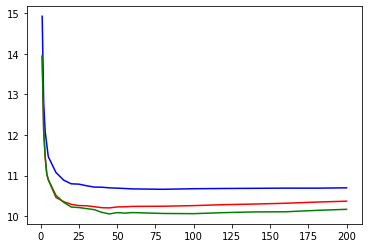

[13.94019368588543, 12.097861381252473, 11.448255568232025, 11.043653909221652, 10.900440969673351, 10.46269085847422, 10.359457586258149, 10.292158827638316, 10.261870966511582, 10.257804039057469, 10.235202506063867, 10.209997388181186, 10.204546360311813, 10.228160003962914, 10.232596529500087, 10.242063661955804, 10.245796391589902, 10.260879617914505, 10.284962306823381, 10.299767106540788, 10.318954408812253, 10.347841640420786, 10.370087243686365]
[14.923638966418345, 12.777499755429464, 12.075674967716129, 11.767805657810635, 11.466392632384432, 11.07746090040493, 10.888979137947995, 10.797788546734928, 10.79007301797969, 10.75026561256701, 10.717738719772289, 10.714437504678756, 10.698494013475852, 10.69110105960404, 10.682608734124413, 10.672535729098724, 10.662907517124493, 10.67701950452466, 10.683139638996407, 10.687017556442052, 10.691630026202155, 10.69071978380711, 10.698853374700175]
[13.94019368588543, 12.097861381252473, 11.448255568232025, 11.043653909221652, 10.900

In [9]:
import matplotlib.pyplot as plt

# case1: knn with standardized feature - red
# case2: knn without standardized feature - blue
# case3: my knn - green

plt.plot(Klist, RMSE_case1, 'r')
plt.plot(Klist, RMSE_case2, 'b')
plt.plot(Klist, RMSE_case3, 'g')
plt.show()
print(RMSE_case1)
print(RMSE_case2)
print(RMSE_case3)


In [ ]:
由上圖可以發現，當k越大時，RMSE越小，即誤差越小，直到某個最低點又很緩慢的回升，呈現U型。
先對feature做標準化的結果，RMSE明顯較位做標準化的還低，預測較準確。
Case1的誤差最低點發生在k=45，Case2的誤差最低點發生在k=80，而Case3的誤差最低點發生在k=120。